<a href="https://colab.research.google.com/github/heromiya/ai_teaching/blob/main/200206_Zambia_Mapping_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Revision records
2021/02/12
* Revision for demonstration in AIT.

2020/02/06
* Formatting and translating for Zambia mapping

2020/01/28
* NIEDミニワークショップ用にラスタライズ機能を追加

2020/01/20
* 地理空間ビッグデータ利活用『持続可能な観光開発』人材育成プログラム用にフォーク

2020/01/07

* First version

#0. Installing prerequisite

In [1]:
%%time 
!apt update
#!apt upgrade
!apt install gdal-bin python-gdal python3-gdal imagemagick python3-rtree python3-rasterio python3-sklearn python3-numpy python3-descartes python3-geopandas parallel bc
!pip install segmentation-models keras==2.3.1 tensorflow==2.2.2

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:15 http

In [2]:
import os, shutil, tempfile, random, glob, cv2, subprocess, errno, datetime, numpy as np, matplotlib.pyplot as plt
os.environ['CURL_CA_BUNDLE']='/etc/ssl/certs/ca-certificates.crt'
import rasterio, rasterio.mask
import tensorflow as tf, keras
import pandas as pd, fiona

from rasterio.merge import merge
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from osgeo import ogr, gdal
from PIL import Image
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import jaccard_score
from PIL import Image
from sklearn.metrics import jaccard_similarity_score
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
from random import shuffle

Using TensorFlow backend.


Upload image data for training to "[root]/img/", annotation vector (polygon) data to "[root]/ann_vec/". In Section 1.2 below, the annotation data is extracted for the extent of the image data with coordinates in Geotiff format.

Image data for training (Geotiff)- 
* [root]/img/hogehoge.tif
* [root]/img/fugafuga.tif
* ...

Annotation vector (polygon) for training -    
* [root]/ann_vec/higehige.gpkg
* [root]/ann_vec/fogafoga.gpkg
* ...



In [3]:
# Directoly/folder prepration
root_folder = './'

training_ann_ras = root_folder + 'ann_ras/'
training_ann_vec = root_folder + 'ann_vec/'
training_img = root_folder + 'img/'
test_img = root_folder + 'test_img/'

os.makedirs(training_ann_vec, exist_ok=True)
os.makedirs(training_img, exist_ok=True)
os.makedirs(training_ann_ras, exist_ok=True)

#patch_root = tempfile.mkdtemp()
patch_root = root_folder + '/patch/'
os.makedirs(patch_root, exist_ok=True)
patch_ann = patch_root + '/patch_ann/'
patch_img = patch_root + '/patch_img/'
patch_pred = patch_root + '/patch_pred/'

model_folder = root_folder + '/model/'

test_results = root_folder + '/test_results/'
timestamp = str(datetime.datetime.now())
log_d = root_folder + "logs/" + timestamp + '/'
os.makedirs(log_d, exist_ok=True) 

os.makedirs(patch_ann, exist_ok=True)
os.makedirs(patch_img, exist_ok=True)
os.makedirs(model_folder, exist_ok=True)
os.makedirs(test_results, exist_ok=True)


In [4]:
!wget http://hawaii.csis.u-tokyo.ac.jp:8081/~heromiya/JPN.zip
!unzip JPN.zip
!mv *.tif img/
!mv *.gpkg ann_vec/

--2021-02-12 05:01:47--  http://hawaii.csis.u-tokyo.ac.jp:8081/~heromiya/JPN.zip
Resolving hawaii.csis.u-tokyo.ac.jp (hawaii.csis.u-tokyo.ac.jp)... 157.82.234.198
Connecting to hawaii.csis.u-tokyo.ac.jp (hawaii.csis.u-tokyo.ac.jp)|157.82.234.198|:8081... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42633677 (41M) [application/zip]
Saving to: ‘JPN.zip’

JPN.zip             100%[===================>]  40.66M  15.8MB/s    in 2.6s    

2021-02-12 05:01:50 (15.8 MB/s) - ‘JPN.zip’ saved [42633677/42633677]

Archive:  JPN.zip
  inflating: 13300211220123221.jpeg.75.tif  
  inflating: 13300211220123330.jpeg.75.tif  
  inflating: 13300211220210231.jpeg.75.tif  
  inflating: 13300211220213020.jpeg.75.tif  
  inflating: 13300211220301111.jpeg.75.tif  
  inflating: 13300211220301112.jpeg.75.tif  
  inflating: 13300211220320201.jpeg.75.tif  
  inflating: 13300211220321201.jpeg.75.tif  
  inflating: 13300211220321330.jpeg.75.tif  
  inflating: 13300211230212332.jpeg.75.tif  
  in

#0-2. Hyper parameters
- patch_size - image size of training patches. Not recommended to modify.
- n_patch - number of training patches in a tile. Greater number will yields higher accuracy, but requires more RAM and time.
- n_epoch - Maximum number of epoch (iteration). Greater number leads higher accuracy. > 100 is recommended for finalizing outputs.
- n_batch - Number of training data for a single process during the training. Greater number leads faster computing and stable learning process while consuming more physical memory.
- learning_rate - If iterations shows unstable changes of accuracy, recommended to set lower values. See [an article](https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10).

###Tips in parameter tuning
- Long computing time --> Increase batch size.
- Out of memory --> decrease batch size and number of patches (n_patch).
- Overfitting -- gaps between training accuracy and validation accuracy are increasing along with epochs. --> incease number of patches (n_epoch).
- Small improvement of training accuracies by epoch --> Increase learning rate.
- Fractuating traning accuraies in a long iterations of epochs --> decrease learning rate.

In [5]:
n_patch = 3 # Too large number sometimes fails in training. More thab 100 is preferred.
batch_size = 8
n_epoch = 20  # preferably >= 100 for operational model.
learning_rate = 0.001 # 0.00003 # 0.001 is a default of Adam in Keras.
decay_rate = learning_rate / n_epoch

patch_size = 64 # multiples of 2^depth

b_nb_ratio = 0.5 # ratio of sampled patch tile with buildings : without buildings. Initital training will reuquire oversampling of buildings. In case of no-building images, it samples (1 - b_nb_ratio) * n_patch patches.
#resolution = 0.298 # Resampling the image. Original image resolution is about 0.3 m/pixel. Oversampling will be needed for balancing building and nonbuilding segments.


#1.Training Dataset Preparation


##1-1. Rasterizing annotation vector data

In [6]:
%%script env SHPDIR="$training_ann_vec" MASKDIR="$training_ann_ras" RASDIR="$training_img" bash
IFS='
'

rm -f merged.gpkg
for VEC in $(find "$SHPDIR" -type f | grep -e ".*\.shp" -e ".*\.sqlite" -e ".*\.gpkg"); do
  ogr2ogr -f gpkg -append -update merged.gpkg $VEC -nln merged
done

rm -rf $MASKDIR
mkdir -p $MASKDIR
function rasterize(){
  IMG=$1
  OUTTIF="$MASKDIR/$(basename "$IMG" | sed 's/\(\.[a-zA-Z]\{3\}\)$/-a\1/g')"
  eval $(gdalinfo "$IMG" | grep Corner -A 4 |  sed 's/^\(.*)\) (.*)$/\1/g' | sed 's/ (/=(/g; s/ //g; s/,/ /' | tail -n 4)  
  eval $(gdalinfo "$IMG" | grep "Pixel Size" | sed 's/ //g;s/,/ /g; s/-//g')
  gdal_rasterize -burn 1 -of GTiff -a_nodata 0 -ot Byte -tr ${PixelSize[0]} ${PixelSize[1]} -te ${LowerLeft[0]} ${LowerLeft[1]} ${UpperRight[0]} ${UpperRight[1]} merged.gpkg "$OUTTIF" 
} 
export -f rasterize
parallel rasterize {} ::: $(find "$RASDIR" -type f -regex ".*\.tif$")


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


##1-2.Generate patch set

In [7]:
%%script env RASDIR="$training_img" MASKDIR="$training_ann_ras" PATRASDIR="$patch_img" PATMASKDIR="$patch_ann" PATCH_SIZE="$patch_size" N_PATCH="$n_patch" B_NB_RATIO="$b_nb_ratio" bash
IFS='
'
rm -rf "$PATMASKDIR" "$PATRASDIR"
mkdir -p "$PATMASKDIR" "$PATRASDIR"
echo "$PATMASKDIR" "$PATRASDIR"
#for TIF in $(find "$RASDIR" -type f | grep -e ".*\.png$" -e ".*\.tif$"); do
function gen_patch() {
    TIF=$1
  IFS=' '

    JSON=$(gdalinfo -json "$TIF")
    SIZE=($(echo $JSON | python3 -c "import sys, json; print(json.load(sys.stdin)['size'])" | tr -d [],))
    X_SIZE=${SIZE[0]}
    Y_SIZE=${SIZE[1]}
    MASK_TIF=$MASKDIR/$(basename "$TIF" | sed 's/\(\.[a-zA-Z]\{3\}\)$/-a\1/g')

    upperRight=($(echo $JSON | python3 -c "import sys, json; print(json.load(sys.stdin)['cornerCoordinates']['upperRight'])" | tr -d [],))
    lowerLeft=($(echo $JSON | python3 -c "import sys, json; print(json.load(sys.stdin)['cornerCoordinates']['lowerLeft'])" | tr -d [],))
    geoTransform=($(echo $JSON | python3 -c "import sys, json; print(json.load(sys.stdin)['geoTransform'])" | tr -d [],))

    PIXEL_SIZE_X=${geoTransform[1]}
    PIXEL_SIZE_Y=$(echo ${geoTransform[5]} | tr -d "-")
    #PIXEL_SIZE_X=$RES
    #PIXEL_SIZE_Y=$RES
    PATCH_SIZE_GX=$(perl -e "print $PATCH_SIZE * $PIXEL_SIZE_X")
    PATCH_SIZE_GY=$(perl -e "print $PATCH_SIZE * $PIXEL_SIZE_Y")
    IMG_EXT="${lowerLeft[0]} ${lowerLeft[1]} ${upperRight[0]} ${upperRight[1]}"
    N_BLD=$(ogrinfo -spat $IMG_EXT merged.gpkg -al -so | grep "Feature Count" | cut -d " " -f 3)

    for C_BLD in $(ogrinfo -spat ${lowerLeft[0]} ${lowerLeft[1]} ${upperRight[0]} ${upperRight[1]} -sql "SELECT ST_Centroid(geom) FROM merged;" -al merged.gpkg | grep POINT | tr -d 'POINT()' | sed "s/^ *//g; s/ /,/" | awk '{printf("%s ",$0)}'); do
      C_BLD=($(echo $C_BLD | sed 's/,/ /'))

      EXT_XMIN=$(perl -e "print ${C_BLD[0]} - $PATCH_SIZE_GX")
      if [ $(echo "$EXT_XMIN < ${lowerLeft[0]}" | bc) -eq 1 ]; then
        EXT_XMIN=${lowerLeft[0]}
      fi

      EXT_YMIN=$(perl -e "print ${C_BLD[1]} - $PATCH_SIZE_GY")
      if [ $(echo "$EXT_YMIN < ${lowerLeft[1]}" | bc) -eq 1 ]; then
        EXT_YMIN=${lowerLeft[1]}
      fi

      # Patches for buildings
      i=1
      while [ $i -le $(perl -e "use POSIX qw(floor ceil); print ceil($N_PATCH * $B_NB_RATIO / $N_BLD)") ]; do
          PATCH_XMIN=$(perl -e "print $EXT_XMIN + rand($PATCH_SIZE_GX)")
          PATCH_YMIN=$(perl -e "print $EXT_YMIN + rand($PATCH_SIZE_GY)")

          if [ $(echo "$(perl -e "print $PATCH_XMIN + $PATCH_SIZE_GX") > ${upperRight[0]}" | bc) -eq 1 ]; then
            PATCH_XMIN=$(perl -e "print ${upperRight[0]} - $PATCH_SIZE_GX")
          fi

          if [ $(echo "$(perl -e "print $PATCH_YMIN + $PATCH_SIZE_GY") > ${upperRight[1]}" | bc) -eq 1 ]; then
            PATCH_YMIN=$(perl -e "print ${upperRight[1]} - $PATCH_SIZE_GY")
          fi

          PATCH_XMAX=$(perl -e "print $PATCH_XMIN + $PATCH_SIZE_GX")
          PATCH_YMAX=$(perl -e "print $PATCH_YMIN + $PATCH_SIZE_GY")

          PATCH_IMG="${PATRASDIR}/$(basename "$TIF")-${PATCH_SIZE}-${PATCH_XMIN}_${PATCH_YMIN}-i.tif"
          PATCH_MASK="${PATMASKDIR}/$(basename "$TIF")-${PATCH_SIZE}-${PATCH_XMIN}_${PATCH_YMIN}-m.tif"

          #gdalwarp -q -r lanczos -tr $RES $RES -te $PATCH_XMIN $PATCH_YMIN $PATCH_XMAX $PATCH_YMAX "$TIF" "$PATCH_IMG"
          #gdalwarp -q -r lanczos  -tr $RES $RES -te $PATCH_XMIN $PATCH_YMIN $PATCH_XMAX $PATCH_YMAX "$MASK_TIF" "$PATCH_MASK"
          gdal_translate -q -projwin $PATCH_XMIN $PATCH_YMAX $PATCH_XMAX $PATCH_YMIN "$TIF" "$PATCH_IMG"
          gdal_translate -q -projwin $PATCH_XMIN $PATCH_YMAX $PATCH_XMAX $PATCH_YMIN "$MASK_TIF" "$PATCH_MASK"

          # Training data augumentation.
          #for OPT in -flip -flop "-rotate 90" "-rotate 180" "-rotate 270"; do 
          #    convert "$PATCH_IMG"  $OPT "${PATRASDIR}/$(basename "$TIF")-${PATCH_SIZE}-${PATCH_XMIN}_${PATCH_YMIN}$(echo $OPT | sed 's/rotate //g')-i.tif" >& /dev/null
          #    convert "$PATCH_MASK" $OPT "${PATMASKDIR}/$(basename "$TIF")-${PATCH_SIZE}-${PATCH_XMIN}_${PATCH_YMIN}$(echo $OPT | sed 's/rotate //g')-m.tif" >& /dev/null
          #done
          # Ending autumentation 

          i=$(expr $i + 1)
      done
    done
        
        # Patches for non-buildings
    j=1
    while [ $j -le $(perl -e "use POSIX qw(floor ceil); print ceil($N_PATCH * (1 - $B_NB_RATIO))") ]; do
        PATCH_XMIN=$(perl -e "print ${lowerLeft[0]} + rand($X_SIZE * $PIXEL_SIZE_X - $PATCH_SIZE_GX)")
        PATCH_YMIN=$(perl -e "print ${lowerLeft[1]} + rand($Y_SIZE * $PIXEL_SIZE_Y - $PATCH_SIZE_GY)")
        PATCH_XMAX=$(perl -e "print $PATCH_XMIN + $PATCH_SIZE_GX")
        PATCH_YMAX=$(perl -e "print $PATCH_YMIN + $PATCH_SIZE_GY")

        PATCH_IMG="${PATRASDIR}/$(basename "$TIF")-${PATCH_SIZE}-${PATCH_XMIN}_${PATCH_YMIN}-i.tif"
        PATCH_MASK="${PATMASKDIR}/$(basename "$TIF")-${PATCH_SIZE}-${PATCH_XMIN}_${PATCH_YMIN}-m.tif"

        #gdalwarp -q -r lanczos -tr $RES $RES -te $PATCH_XMIN $PATCH_YMIN $PATCH_XMAX $PATCH_YMAX "$TIF" "$PATCH_IMG"
        #gdalwarp -q -r lanczos -tr $RES $RES -te $PATCH_XMIN $PATCH_YMIN $PATCH_XMAX $PATCH_YMAX "$MASK_TIF" "$PATCH_MASK"
        gdal_translate -q -projwin $PATCH_XMIN $PATCH_YMAX $PATCH_XMAX $PATCH_YMIN "$TIF" "$PATCH_IMG"
        gdal_translate -q -projwin $PATCH_XMIN $PATCH_YMAX $PATCH_XMAX $PATCH_YMIN "$MASK_TIF" "$PATCH_MASK"
        # Training data augumentation.
        #for OPT in -flip -flop "-rotate 90" "-rotate 180" "-rotate 270"; do 
        #    convert "$PATCH_IMG"  $OPT "${PATRASDIR}/$(basename "$TIF")-${PATCH_SIZE}-${PATCH_XMIN}_${PATCH_YMIN}$(echo $OPT | sed 's/rotate //g')-i.tif" >& /dev/null
        #    convert "$PATCH_MASK" $OPT "${PATMASKDIR}/$(basename "$TIF")-${PATCH_SIZE}-${PATCH_XMIN}_${PATCH_YMIN}$(echo $OPT | sed 's/rotate //g')-m.tif" >& /dev/null
        #done
        # Ending autumentation 

        j=$(expr $j + 1)
    done
#done
}
export -f gen_patch
parallel gen_patch {} ::: $(find "$RASDIR" -type f -regex ".*\.tif$")

.//patch//patch_ann/ .//patch//patch_img/


# 2. Applying convolutional nueral network

##2-1. Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts. 

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size 
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input. 

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1. 


![alt text](https://blog.playment.io/wp-content/uploads/2018/03/Screen-Shot-2018-09-05-at-3.00.03-PM.png)

## 2-2. Image generators

In [8]:
def image_generator(files, batch_size = batch_size, sz = (patch_size, patch_size)):
  #print(files)
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    for f in batch:
        
        #get the masks. Note that masks are png files 
        try:
          mask = Image.open(patch_ann  + '/' + f.replace('-i','-m'))
        except:
          continue
        mask = np.array(mask.resize(sz))
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(patch_img + '/' + f)
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)
        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)      
    

In [9]:
all_files = os.listdir(patch_img)
shuffle(all_files)

split = int(0.8 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

x, y= next(train_generator)

Displaying an example of training patch image. You may change the array index to see other examples.

(64, 64, 3)


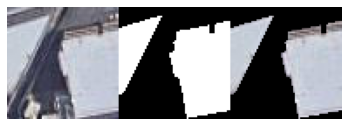

In [11]:
plt.axis('off')
i = 1
img = x[i]
msk = y[i].squeeze()
msk = np.stack((msk,)*3, axis=-1)
print(img.shape)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

##2-2. IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $x_{true}, x_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

詳しくはhttps://mathwords.net/iou

In [12]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

##2-3. Model
Choose a cell to execute for 2-3-1 Without pre-trained model or 2-3-2 With pre-trained model.

FYI - an option "decay" is for decaying learning rate in optimizers, which sometimes useful to complex problems. See [the guide](https://keras.io/optimizers/) for details.



In [16]:
import segmentation_models as sm # https://github.com/qubvel/segmentation_models
#model = sm.Unet('resnet34', classes=1, activation='sigmoid')
model = sm.FPN('efficientnetb2', classes=1, activation='sigmoid')
model.compile(
    optimizer = Adam(lr=learning_rate),
    loss = sm.losses.bce_jaccard_loss,
    metrics = ['accuracy',sm.metrics.iou_score]
)


##2-4. Callbacks

Simple functions to save the model at each epoch and show some predictions. See [Keras user guide](https://keras.io/callbacks/#modelcheckpoint) for file naming of models

In [17]:
def build_callbacks():
    checkpointer = ModelCheckpoint(filepath = log_d + '/weights.' + timestamp + '.{epoch:04d}-{val_loss:.4f}.hdf5', verbose=0, save_weights_only=True, save_best_only=True)
    callbacks = [checkpointer,PlotLearning()]
    return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
        
    def on_epoch_end(self, epoch, logs={}):
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(patch_img + f'/{path}')
        raw = np.array(raw)/255.
        #print(raw.shape)
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()
        

##2-5. Training

Epoch 1/20
300/300 [==============================] - 211s 703ms/step - loss: 0.5962 - accuracy: 0.8842 - iou_score: 0.6938 - val_loss: 0.6697 - val_accuracy: 0.8820 - val_iou_score: 0.6763


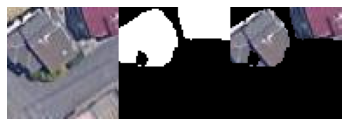

Epoch 2/20
300/300 [==============================] - 182s 606ms/step - loss: 0.4165 - accuracy: 0.9239 - iou_score: 0.7840 - val_loss: 0.8125 - val_accuracy: 0.9178 - val_iou_score: 0.7743


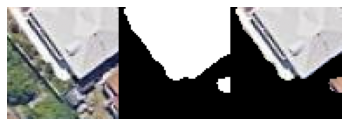

Epoch 3/20
300/300 [==============================] - 183s 611ms/step - loss: 0.3743 - accuracy: 0.9324 - iou_score: 0.8058 - val_loss: 0.3912 - val_accuracy: 0.9245 - val_iou_score: 0.7957


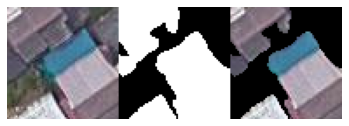

Epoch 4/20
300/300 [==============================] - 184s 614ms/step - loss: 0.3258 - accuracy: 0.9411 - iou_score: 0.8304 - val_loss: 0.3734 - val_accuracy: 0.9301 - val_iou_score: 0.8116


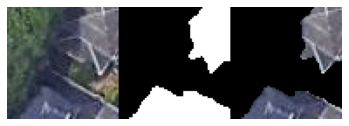

Epoch 5/20
300/300 [==============================] - 181s 603ms/step - loss: 0.3066 - accuracy: 0.9448 - iou_score: 0.8410 - val_loss: 0.2678 - val_accuracy: 0.9310 - val_iou_score: 0.8010


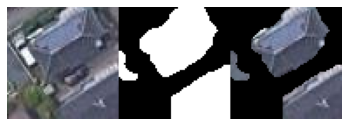

Epoch 6/20
115/300 [==========>...................] - ETA: 1:45 - loss: 0.2956 - accuracy: 0.9476 - iou_score: 0.8428

KeyboardInterrupt: ignored

In [18]:
train_steps = len(train_files)/batch_size
test_steps = len(test_files)/batch_size
model_history = model.fit_generator(train_generator, 
                    epochs = n_epoch, 
                    steps_per_epoch = train_steps,
                    validation_data = test_generator, 
                    validation_steps = test_steps,
                    callbacks = build_callbacks(), 
                    verbose = 1)

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(n_epoch)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0.0, 1.0])
plt.legend()
plt.show()

##2-6. Testing - Applying the model to the images.

In [ ]:
%%script env RASDIR="$training_img" MASKDIR="$training_ann_ras" PATRASDIR="$patch_img" PATMASKDIR="$patch_ann" PATCH_SIZE="$patch_size" N_PATCH="$n_patch" bash

IFS='
'
rm -rf $PATMASKDIR $PATRASDIR
mkdir -p $PATMASKDIR $PATRASDIR
echo $PATMASKDIR $PATRASDIR

for TIF in $(find "$RASDIR" -type f | grep -e "\.png$" -e "\.tif$"); do
  IFS=' '
  JSON=$(gdalinfo -json "$TIF")
  SIZE=($(echo $JSON | python3 -c "import sys, json; print(json.load(sys.stdin)['size'])" | tr -d [],))
  X_SIZE=${SIZE[0]}
  Y_SIZE=${SIZE[1]}
  #N_PATCH_X=$(expr $(expr $X_SIZE / $PATCH_SIZE) + 1)
  #N_PATCH_Y=$(expr $(expr $Y_SIZE / $PATCH_SIZE) + 1)
  N_PATCH_X=$(perl -e "use POSIX qw(floor ceil); print ceil($X_SIZE / $PATCH_SIZE)")
  N_PATCH_Y=$(perl -e "use POSIX qw(floor ceil); print ceil($Y_SIZE / $PATCH_SIZE)")  
  X_SIZE_EXTEND=$(expr $N_PATCH_X \* $PATCH_SIZE)
  Y_SIZE_EXTEND=$(expr $N_PATCH_Y \* $PATCH_SIZE)
  gdal_translate -srcwin 0 0 $X_SIZE_EXTEND $Y_SIZE_EXTEND "$TIF" "$PATRASDIR/$(basename "$TIF")-i.tif"
  
done


In [ ]:

log_d = root_folder + '/logs/2020-02-12 01:07:10.756811'
best_weight = log_d + '/' + sorted(os.listdir(log_d), reverse=True)[0] 

im = Image.open(patch_img + os.listdir(patch_img)[0])
out_patch_size = im.size[0]
print(patch_img)

out_model = unet(out_patch_size, best_weight)

try:
    shutil.rmtree(patch_pred)
except:
    pass

os.makedirs(patch_pred, exist_ok=True)

all_files = os.listdir(patch_img)
for f in all_files:
  if f.endswith(".tif"):
    raw = Image.open(patch_img + '/' + f)
    raw = np.array(raw)
    raw = np.array(raw)/255.
    raw = raw[:,:,0:3]

    pred = out_model.predict(np.expand_dims(raw, 0))
    pred[pred >= 0.5] = 1
    pred[pred < 0.5] = 0
    pred = pred.astype(np.uint8).reshape([out_patch_size,out_patch_size])
    im = Image.fromarray(pred)
    im.save(patch_pred + '/' + f + '.pred.tif')

In [ ]:
%%script env RASDIR="$training_img" MASKDIR="$training_ann_ras" PATRASDIR="$patch_img" PATMASKDIR="$patch_ann" PATCH_SIZE="$patch_size" PATPRED="$patch_pred" TEST_RESULTS="$test_results" bash
IFS='
'
mkdir -p $TEST_RESULTS

for IMG_EXTENDED in $(find $PATRASDIR -type f -regex ".*tif$"); do
    IFS=' '
    JSON=$(gdalinfo -json "$IMG_EXTENDED")
    SIZE=($(echo $JSON | python3 -c "import sys, json; print(json.load(sys.stdin)['size'])" | tr -d [],))
    X_SIZE=${SIZE[0]}
    Y_SIZE=${SIZE[1]}

    PRED_TIF=$PATPRED/$(basename "$IMG_EXTENDED").pred.tif

    upperLeft=($(echo $JSON | python3 -c "import sys, json; print(json.load(sys.stdin)['cornerCoordinates']['upperLeft'])" | tr -d [],))
    lowerRight=($(echo $JSON | python3 -c "import sys, json; print(json.load(sys.stdin)['cornerCoordinates']['lowerRight'])" | tr -d [],))

    gdal_translate -q -ot Byte -a_srs EPSG:3857 -a_ullr ${upperLeft[0]} ${upperLeft[1]} ${lowerRight[0]} ${lowerRight[1]} "$PRED_TIF" "$TEST_RESULTS/$(basename "$PRED_TIF").g.tif"

done

# トラブルシューティング

1. val_mean_iouがずっとゼロのまま <-- learning rateを小さくしてみてください。

2. モデルのlossが小さくなる（mean_iouが大きくなる）一方で、validation lossが大きくなる（val_mean_iouが小さくなる）つづけている <-- Overfitting 過学習が起こっています。n_patchでサンプル数を増やしてみましょう。

3. 計算に時間がかかる <-- batch_size をメモリ容量が許すまで目一杯大きくしましょう。

4. どうしても精度が上がらない <-- トレーニングデータの手入力精度に問題があるかもしれません。トレーニングデータの手直しをしてみましょう。分解能 spatial resolution をそろえるのも効果的です。